### Script for reading data for Problem 5.1 (data_AlgaeGrowth.txt) in Applied Statistics 2021 exam:

This script reads the file __"data_AlgaeGrowth.txt"__ for Problem 5.1 in the exam of Applied Statistics 2021/22. This data files contains 90 entries in three columns: 
* **time** (hours) of measurement,
* **area** ($\mathrm{cm}^2$) of the algae coverage,
* **area uncertainty** ($\mathrm{cm}^2$).

The script was distributed along with the exam and the data file itself on the 20th of January 2022.

####  Author: 
- Troels Petersen (Niels Bohr Institute, petersen@nbi.dk)

####  Date:   
 - 19th of January 2022 (first version)

In [7]:
import random
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats
from scipy.stats import binom, poisson, norm ,gamma           # Functions from SciPy Stats...
# import scipy.optimize as optimization
from scipy import optimize
from numpy.linalg import inv
from functools import partial
from fitter import Fitter
from astropy.modeling import models, fitting

In [8]:
import pandas as pd

In [9]:
sys.path.append('D:\my github\Siyi Applied Stats\Documents for JN\AppStat2021-main\External_Functions\\')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

plt.rcParams['font.size'] = 18     # Set some basic plotting parameters

In [10]:
dataframe = pd.read_csv('data_AlgaeGrowth.csv', header=0, index_col=None)
time, area, err_area = dataframe.values.T
dataframe

,time(days),area(cm2),err_area(cm2)
0,0.35,1470.40,45.0
1,0.57,1426.93,45.0
2,0.60,1466.84,45.0
3,0.90,1580.44,45.0
4,1.08,1626.27,45.0
...,...,...,...
85,11.71,1974.83,45.0
86,11.85,2044.98,45.0
87,11.93,2059.38,45.0
88,12.26,2014.04,45.0


Print the first 10 entries to check the content of the file:

In [11]:
for i in range(10):
    print(f"  time = {time[i]:4.2f} hrs    area = {area[i]:6.2f} cm2    err_area = {err_area[i]:5.2f} cm2")

  time = 0.35 hrs    area = 1470.40 cm2    err_area = 45.00 cm2
  time = 0.57 hrs    area = 1426.93 cm2    err_area = 45.00 cm2
  time = 0.60 hrs    area = 1466.84 cm2    err_area = 45.00 cm2
  time = 0.90 hrs    area = 1580.44 cm2    err_area = 45.00 cm2
  time = 1.08 hrs    area = 1626.27 cm2    err_area = 45.00 cm2
  time = 1.30 hrs    area = 1624.67 cm2    err_area = 45.00 cm2
  time = 1.51 hrs    area = 1559.46 cm2    err_area = 45.00 cm2
  time = 1.64 hrs    area = 1577.22 cm2    err_area = 45.00 cm2
  time = 1.86 hrs    area = 1626.99 cm2    err_area = 45.00 cm2
  time = 2.03 hrs    area = 1710.10 cm2    err_area = 45.00 cm2


[ 0.35  0.57  0.6   0.9   1.08  1.3   1.51  1.64  1.86  2.03  2.42  2.48
  2.84  3.02  3.13  3.18  3.26  3.46  3.59  3.64  3.65  3.67  3.67  3.68
  4.09  4.12  4.18  4.2   4.32  4.51  4.6   4.85  4.94  5.12  5.18  5.44
  5.48  5.74  5.99  6.23  6.26  6.83  7.57  7.59  7.83  7.85  7.91  8.36
  8.63  8.69  8.8   8.86  8.99  9.07  9.16  9.2   9.38  9.38  9.38  9.41
  9.47  9.64  9.69  9.73  9.76  9.79  9.87 10.03 10.05 10.12 10.16 10.26
 10.37 10.41 10.47 10.53 10.6  10.66 10.71 10.74 10.79 10.82 11.22 11.34
 11.37 11.71 11.85 11.93 12.26 12.99] [1470.4  1426.93 1466.84 1580.44 1626.27 1624.67 1559.46 1577.22 1626.99
 1710.1  1606.8  1611.75 1708.74 1732.43 1782.39 1751.08 1711.96 1715.81
 1691.19 1740.05 1735.1  1700.67 1710.37 1724.18 1775.09 1816.78 1781.84
 1779.4  1742.82 1739.38 1764.28 1839.63 1865.11 1872.99 1844.71 1771.35
 1791.06 1813.8  1895.14 1858.38 1852.45 1893.08 1832.45 1817.25 1917.71
 1963.3  1914.16 1888.34 1904.56 1915.91 1942.39 1951.25 2028.09 1991.78
 1985.41 1973

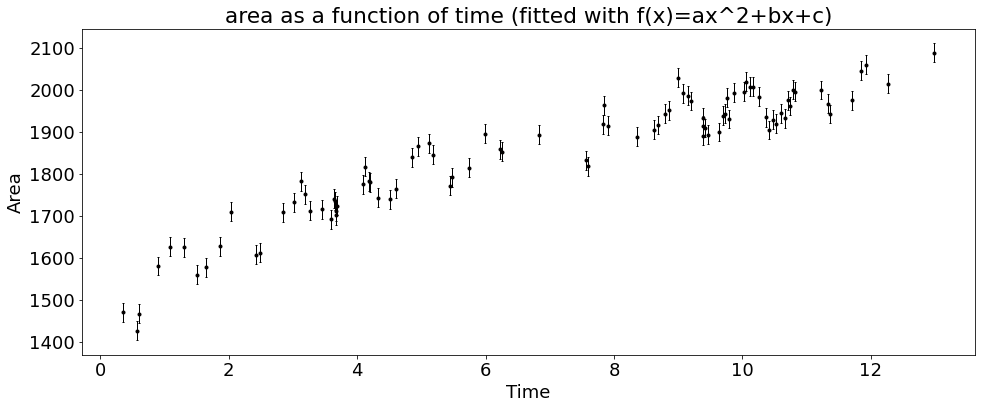

In [110]:
x = time
y = area
sy = err_area/2

fig, ax = plt.subplots(figsize=(16, 6))  # figsize is in inches
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='error = relative 45%', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

ax.plot(x, y,'ro',markersize=2)
ax.set(xlabel="Time", # the label of the y axis
       ylabel="Area",  # the label of the y axis
       title="area as a function of time (fitted with f(x)=ax^2+bx+c)"# the title of the plot
      ) # Setting the miminum to zero

print(x,y)
#plt.savefig('fig1',dpi=600)
#fig.tight_layout()

In [111]:

def fit_pdf(x,a,b,c,d,p0,p1,p2):
    return (a*x**3 + b*x**2+ c*x + d)+p0*np.cos(p1*x+p2)


In [112]:

Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)

# Defining Chi2 calculation:
def chi2_owncalc(a,b,c,d,p0,p1,p2) :
    y_fit = fit_pdf(x,a,b,c,d,p0,p1,p2)
    chi2 = np.sum(((y - y_fit) / sy)**2)
    return chi2

# Alternatively, use the Chi2 regression from External Functions:
chi2fit = Chi2Regression(fit_pdf, x, y, sy)

minuit_chi2 = Minuit(chi2_owncalc,a=2,b=3,c=2,d=1400,p0=2,p1=2,p2=2)
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
minuit_chi2.migrad()           # This is where the minimisation is carried out! Put ";" at the end to void output


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 278.6                      │             Nfcn = 1147              │
│ EDM = 0.00925 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           ABOVE call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    1.7    │    0.5    │            │            │         │         │       │
│ 1 │ b    │    -36    │    10     │            │            │         │         │       │
│ 2 │ c    │    230    │    40     │            │            │         │         │       │
│ 3 │ d    │  1.40e3   │  0.06e3   │            │            │         │         │       │
│ 4 │ p0   │   -120    │    80     │            │            │         │         │       │
│ 5 │ p1   │   0.48    │   0.10    │            │            │         │         │       │
│ 6 │ p2   │    4.7    │    0.6    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────────────────────┐
│    │         a         b         c         d        p0        p1        p2 │
├────┼───────────────────────────────────────────────────────────────────────┤
│  a │     0.259     -5.18      19.4      23.6     -40.4   -0.0438     0.268 │
│  b │     -5.18       104      -389      -475       810     0.881     -5.38 │
│  c │      19.4      -389   1.5e+03  1.49e+03 -2.89e+03     -2.98        18 │
│  d │      23.6      -475  1.49e+03  4.04e+03 -4.65e+03     -6.09      38.2 │
│ p0 │     -40.4       810 -2.89e+03 -4.65e+03  6.82e+03      7.91     -48.8 │
│ p1 │   -0.0438     0.881     -2.98     -6.09      7.91   0.00985   -0.0612 │
│ p2 │     0.268     -5.38        18      38.2     -48.8   -0.0612     0.384 │
└────┴───────────────────────────────────────────────────────────────────────┘

In [118]:

# First, check if the result was a valid minimum:
if (not minuit_chi2.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    
    
# Short hand way of accessing the fit parameters:
fit_a,fit_b,fit_c,fit_d,fit_p0,fit_p1,fit_p2= minuit_chi2.values[:]   # The fitted values of the parameters

# Loop to get both parameter values and uncertainties:
for name in minuit_chi2.parameters :
    value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
    print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

# Get Chi2 value:
chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

# Get number of degrees-of-freedom (Ndof):
N_NotEmptyBin = np.sum(y > 0)
Ndof_value = N_NotEmptyBin - minuit_chi2.nfit

Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.3f}")


Fit value: a = 1.68107 +/- 0.50843
Fit value: b = -35.65852 +/- 10.18920
Fit value: c = 232.43005 +/- 38.72145
Fit value: d = 1400.22446 +/- 63.59698
Fit value: p0 = -115.22277 +/- 82.56686
Fit value: p1 = 0.48171 +/- 0.09927
Fit value: p2 = 4.71430 +/- 0.61934
Chi2 value: 278.6   Ndof = 83    Prob(Chi2,Ndof) = 0.000


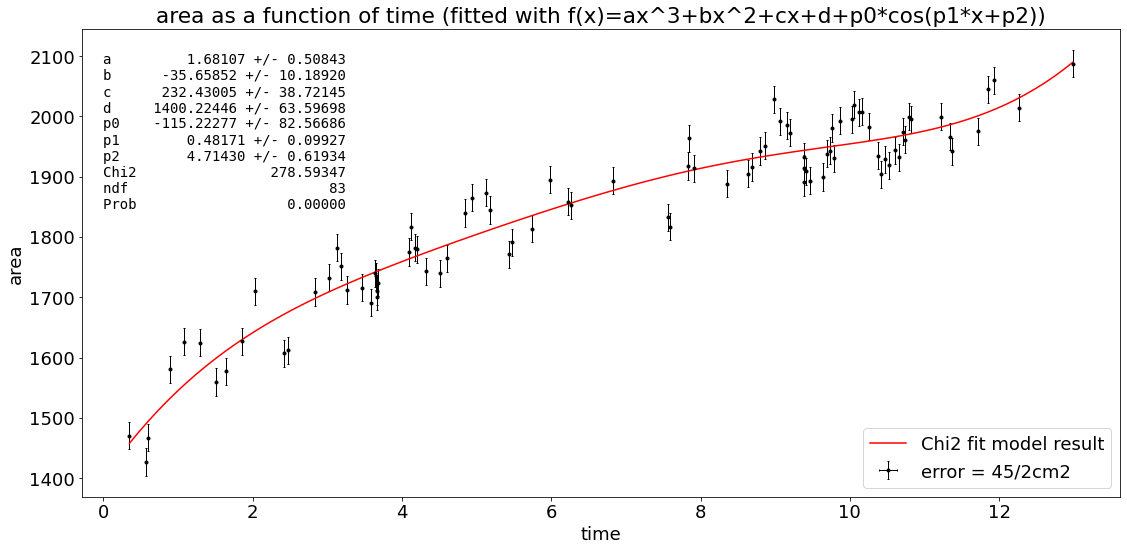

In [116]:

fig, ax = plt.subplots(figsize=(16, 8))  # figsize is in inches
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='error = 45/2cm2', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="time", # the label of the y axis
       ylabel="area",  # the label of the y axis
       title="area as a function of time (fitted with f(x)=ax^3+bx^2+cx+d+p0*cos(p1*x+p2))"# the title of the plot
      ) # Setting the miminum to zero
x_axis = np.linspace(np.min(time), np.max(time), 100)
ax.plot(x_axis, fit_pdf(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result') 

# Adding fit results to plot:
d = {'a': [minuit_chi2.values['a'], minuit_chi2.errors['a']],
     'b': [minuit_chi2.values['b'], minuit_chi2.errors['b']],
     'c': [minuit_chi2.values['c'], minuit_chi2.errors['c']],
     'd': [minuit_chi2.values['d'], minuit_chi2.errors['d']],
     'p0': [minuit_chi2.values['p0'], minuit_chi2.errors['p0']],
     'p1': [minuit_chi2.values['p1'], minuit_chi2.errors['p1']],
     'p2': [minuit_chi2.values['p2'], minuit_chi2.errors['p2']],
     'Chi2':     chi2_value,
     'ndf':      Ndof_value,
     'Prob':     Prob_value,
    }

text = nice_string_output(d, extra_spacing=2, decimals=5)
add_text_to_ax(0.02, 0.95, text, ax, fontsize=14)
ax.legend(loc='lower right', fontsize=18); # could also be # loc = 'upper right' e.g.

fig.tight_layout()
plt.savefig('fig17',dpi=600)


In [99]:
def residuals_pdf(x):
    return (2.15653*x**3 + -44.94541*x**2+ 260.93685*x + 1477.25984)+-206.74745*np.cos(0.42256*x+5.10011)

In [100]:
residuals=np.zeros_like(y)

for j in range(90):
    residuals[j]=y[j]-residuals_pdf(x[j])
print(residuals.size)

p=0  # >0, + 
q=0  # <0, -
for m in range(90):
    if residuals[m]>0:
        p += 1
    if residuals[m]<0:
        q += 1
print(p,q)

residuals_d=np.zeros_like(residuals)
for n in range(90):
    if residuals[n]>0:
        residuals_d[n]=1
    else:
        residuals_d[n]=0
print(residuals_d)

90
42 48
[1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0.]


In [101]:
y_0=np.zeros_like(y)
for k in range(90):
    y_0[k]=0
print(y_0.size)

90


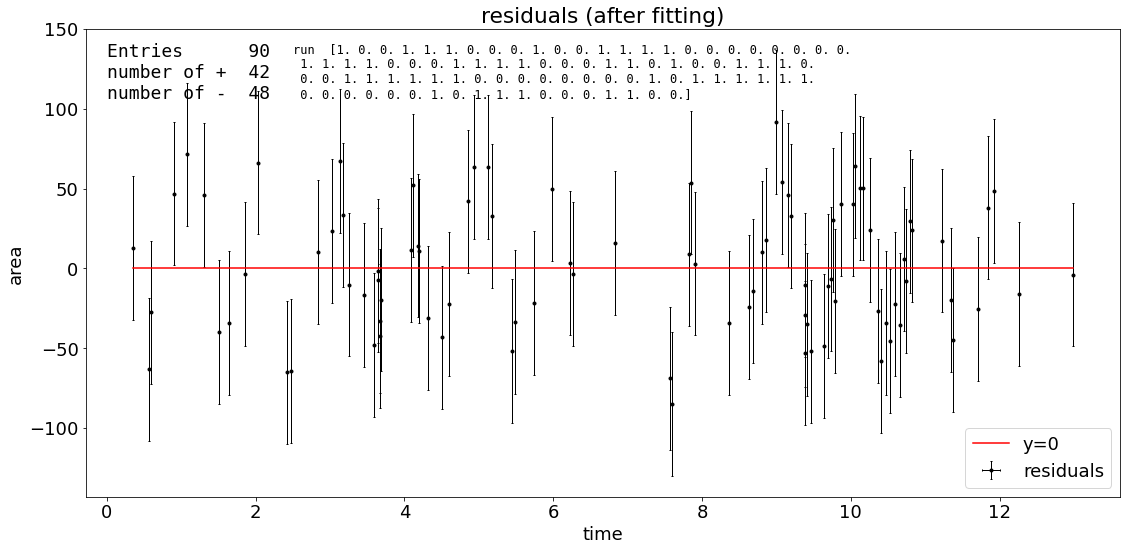

In [103]:

fig, ax2 = plt.subplots(figsize=(16, 8))  # figsize is in inches
ax2.errorbar(x, residuals, yerr=sy, xerr=0.0, label='residuals', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)
ax2.plot(x, y_0, '-r', label='y=0') 

# Set the figure texts; xlabel, ylabel and title.
ax2.set(xlabel="time", # the label of the y axis
       ylabel="area",  # the label of the y axis
       title="residuals (after fitting)"# the title of the plot
      ) # Setting the miminum to zero


# Define the figure text
d2 = {'Entries': len(residuals),
      'number of +': p,      
      'number of -': q,
    }

d3 = {
      'run':residuals_d
    }

# Add figure text
text = nice_string_output(d2, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.97, text, ax2, fontsize=18)
text = nice_string_output(d3, extra_spacing=2, decimals=3)
add_text_to_ax(0.2, 0.97, text, ax2, fontsize=12)

ax2.legend(loc='lower right', fontsize=18); # could also be # loc = 'upper right' e.g.

fig.tight_layout()
plt.savefig('fig16',dpi=600)


In [105]:
N_a= 15  # runs of a
N_b=15 # runs of b
N = N_a+N_b  # sum run
mean = 1+ (2*N_a*N_b)/N
variance = (2*N_a*N_b*(2*N_a*N_b-N))/(N**2*(N-1))
sigma = np.sqrt(variance)
print("mean is：%f" %mean,"sigma is：%f" %sigma, "variance is：%f" %variance)

mean is：16.000000 sigma is：2.690981 variance is：7.241379


In [106]:
5/2.69

1.858736059479554

In [108]:
print(residuals)
z=np.sqrt(np.sum(residuals)/90)
print(z)

[ 12.74367082 -63.29358649 -27.59042269  46.80143284  71.42168884
  46.01211883 -39.96493492 -34.19084742  -3.33760324  66.21957785
 -65.18122761 -64.2317116   10.25066609  23.51531483  67.33298401
  33.28323204 -10.1569223  -16.79628117 -48.02307273  -1.66464807
  -7.11247922 -42.53571786 -32.83571786 -19.52114014  11.67891316
  51.9669464   14.2370981   10.87118923 -31.22419677 -43.26836819
 -22.39431998  41.92261151  63.48122485  63.59470995  32.74818726
 -51.60313994 -33.56485457 -21.55766667  49.69945114   3.50861435
  -3.58145747  15.92393488 -68.98698986 -84.78664225   8.72455394
  53.75624607   2.96059659 -34.36061915 -24.29283319 -14.2389772
   9.92756551  17.55846853  91.80958329  53.9532557   45.8822472
  32.76831482 -52.84044867 -29.45044867 -10.32044867 -35.14448693
 -52.06512725 -48.68001899 -10.95508775  -6.53627182  30.32545009
 -20.47302535  40.30135313  40.04878994  64.13382179  50.41027801
  50.05503345  23.88743683 -26.53423    -57.92981801 -34.19246065
 -45.4669664